In [1]:
%matplotlib inline

import imageio
import matplotlib.pylab as plt
import skimage
import skimage.morphology
import skimage.feature
import scipy
import numpy as np

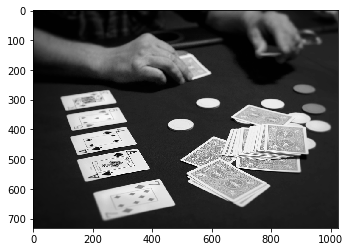

In [2]:
img = imageio.imread('https://upload.wikimedia.org/wikipedia/commons/1/14/Holdem.jpg')
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap=plt.cm.gray)

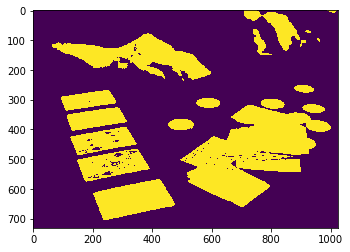

In [3]:
thresh = skimage.filters.threshold_otsu(img)
mask = img > thresh
plt.imshow(mask)

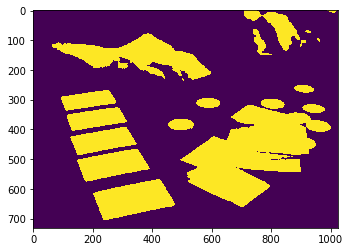

In [4]:
mask = skimage.morphology.remove_small_holes(mask, area_threshold=500)
plt.imshow(mask)

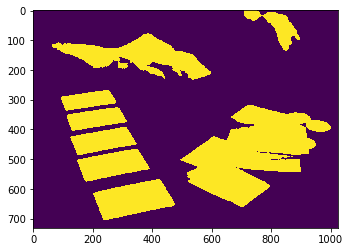

In [5]:
mask = skimage.morphology.remove_small_objects(mask, min_size=5000)
plt.imshow(mask)

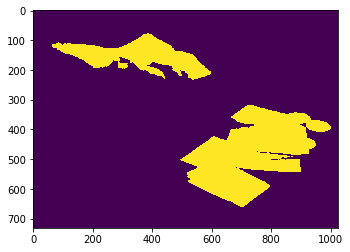

In [6]:
mask_only_big = skimage.morphology.remove_small_objects(mask, min_size=30000)
plt.imshow(mask_only_big)

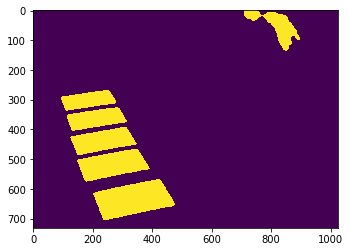

In [7]:
mask = np.logical_xor(mask, mask_only_big)
plt.imshow(mask)

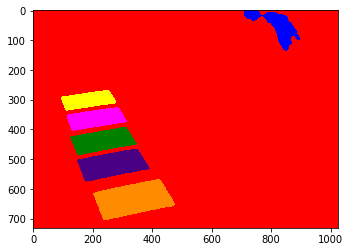

In [8]:
labels = skimage.measure.label(mask)
labels_rgb = skimage.color.label2rgb(labels)
plt.imshow(labels_rgb)

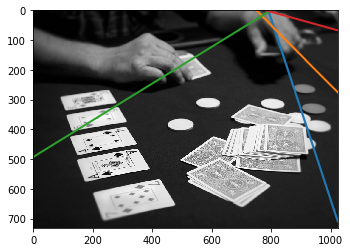

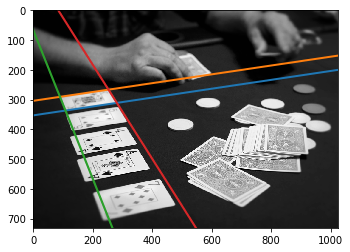

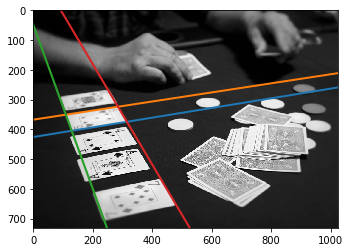

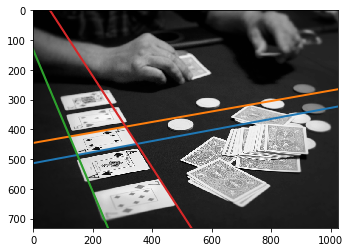

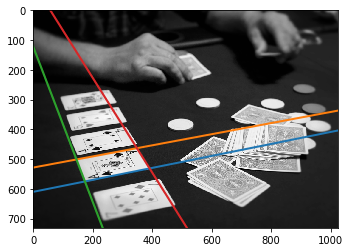

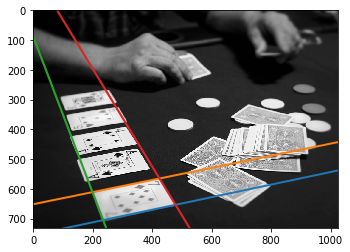

In [9]:
for card_index in np.unique(labels):
    if card_index == 0:
        continue
        
    # get mask of card
    this_card = labels == card_index
    
    # get border of card
    this_card = np.logical_xor(this_card, skimage.morphology.erosion(this_card))

    # find XY coords of all points on border of card
    this_card_points = np.array(np.where(this_card)).T
    
    plt.figure()
    plt.imshow(img, cmap=plt.cm.gray)    
    
    # search for 4 lines
    for _ in range(4):
        
        # use Ransac to fit a line model
        model, inliers = skimage.measure.ransac(this_card_points, skimage.measure.LineModelND, min_samples=2,
                                   residual_threshold=1, max_trials=1000)
        
        # plot the found line
        x = np.arange(img.shape[1])
        y = model.predict_y(x).astype(np.int)
        plt.plot(y, x, lw=2)
        
        # this are the parameters of the line
        origin = model.params[0]
        vector = model.params[1]
        
        # remove the points on the line (i.e. the inliers) form the XY coordinates in which we search for lines
        this_card_points = this_card_points[~inliers,:]
        
    # things to do:
    #  * check if there are 2 pairs of 2 parallel lines (i.e. similar vector) and if not skip the card
    #  * compute the intersection points of the lines (i.e. the corners of the card)
    #  * use e.g. PiecewiseAffineTransform and warp from skimage.transform to "extract" the card
        
    plt.xlim(0, img.shape[1])    
    plt.ylim(img.shape[0], 0)    